In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from scipy.fft import rfft, rfftfreq
from scipy.fft import fft2
from skimage.filters import window


import os
import sys
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.insert(0, os.path.join(parent_dir, 'pysta2'))

import pysta
# import stc
# import stcl

# from stcl import load_centers

import pandas as pd
import os

%load_ext autoreload
%autoreload 2

In [2]:
# helper functions for visualization
def box_off():
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def p2p(sta):
    return np.max(sta) - np.min(sta)

def psnr(sta):
    return (np.max(sta.ravel()) - np.min(sta.ravel())) / np.std(sta.ravel())


def plot_temporal_profile(sta, dt):
    tap = sta.shape[-1]
#     figsize = (5.5,3.5)
#     plt.figure(figsize=figsize)
    pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
    plt.ylabel('STA')
    print('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
    # print('PSNR = {:.2f}'.format(psnr(sta)))

    plt.title('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
#     plt.xlabel('ms')
    
    
def plot_temporal_spectrum(sta, dt):
    wt = rfft(sta, axis=1)
    
    N = sta.shape[1]
    fs = rfftfreq(N, dt)
    
    plt.plot(fs, np.abs(wt.T), 'o-')
    plt.xlabel('Hz')
    plt.ylabel('FFT amplitude')

    box_off()


def plot_spatial_spectrum(sta_slice, windowing='hann', pixel_size=1, precision=0):
    assert len(sta_slice.shape)==2
    
    def set_ticks(ax, fs, precision=precision):
        ticks = range(0, len(fs))
        ticklabels = fs

        #         ticklabels = ["{:.0f}".format(p) for p in (fs[:half_N+1]/pixel_size)]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticklabels)
        ax.set_xlim(-0.5, len(fs)-0.5)
#         from matplotlib.ticker import FormatStrFormatter
#         ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        
        ax.set_yticks(ticks)
        ax.set_yticklabels(ticklabels)
        ax.set_ylim(-0.5, len(fs)-0.5)

        
    w = fft2(sta_slice * window(windowing, sta_slice.shape))

    fs = rfftfreq(sta_slice.shape[0])
    
    plt.imshow(np.abs(w[:len(fs),:len(fs)]), cmap='gray', origin='lower')

    set_ticks(plt.gca(), fs, precision=3)
    
    plt.xlabel('frequency')
    plt.ylabel('frequency')
    
    
def plot_spatio_temporal(sta, height=13, width=13, dt=1000/30, ylabel=None, fig_basename=None):        
    tap = sta.shape[-1]
    figsize = (5.5,3.5)
    plt.figure(figsize=figsize)
    
    plot_temporal_profile(sta, dt)
    
    
#     pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
#     if ylabel is not None:
#         plt.ylabel(ylabel)
#     print('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
#     print('PSNR = {:.2f}'.format(psnr(sta)))
# #     plt.title('peak diff. = {:.2f}'.format(p2p(sta)))
#     plt.xlabel(None)

    if fig_basename is not None:
        plt.savefig(fig_basename + '_temp.pdf', bbox_inches='tight') # https://stackoverflow.com/a/4046233

    plt.figure()
    pysta.plot_stim_slices(sta, height=height, width=width, dt=dt, vmin=-0.5, vmax=0.5)

#     plt.tight_layout()
    
    if fig_basename is not None:
        plt.savefig(fig_basename + '_spatial.pdf', bbox_inches='tight')
    
    
def groupby_dict(df, col, group):
    data = dict()
    for group_val, d in df.groupby(group):
#         print(group_val)
        data[group_val] = d[col].to_list()
    return data


def plot_bar_by_group(info, col, 
                      groupby='cell_type', 
                      group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown'], color=['r','#00A0FF','green', '#A0A0A0']):
    
    means = info.groupby(groupby)[col].mean()[group_values]
    sems = info.groupby(groupby)[col].sem()[group_values]

    plt.bar(group_values, means, yerr=sems,
            width=0.4, color=color, edgecolor='k', linewidth=1,
            capsize=5)
    
    plt.ylabel(col)
    plt.xlabel('cell type')
    
    plt.xlim(-0.5, len(group_values)-0.5)
    box_off()

Let's re-plot old Figure 3 (ON-OFF cell) for all the methods

## load data

In [3]:
# data_path = 'data'

# # dataset = '20201209'
# # width = 26
# # height = 26

# # dataset = '20201216'
# # width = 13
# # height = 13

# dataset = '20180626'
# width = 8
# height = 8
# fps = 10

In [4]:
# different spatial & temporal resolutions (2018.08.28)
data_path = 'data'

width = 8
height = 8
fps = 10

# width = 8
# height = 8
# fps = 25

# width = 13
# height = 13
# fps = 10

# width = 26
# height = 26
# fps = 10

dataset = '20180828_{}pix_{}Hz'.format(width,fps)
dataset

'20180828_8pix_10Hz'

In [5]:
# gaussian stim with the highest contrast
data_path = 'data_gaussian'
dataset = 'contrast100'

width = 8
height = 8
fps = 10

In [6]:
data = np.load(os.path.join(data_path, dataset + '.npz'))
info = pd.read_csv(os.path.join(data_path, dataset + '_info.csv'))


stim = data['stim'] - 0.5
spike_counts = data['spike_counts']

len(info)

106

In [7]:
if fps == 10:
    tap = 8
elif fps == 25:
    tap = 20

## calc STA and peak-to-peak difference for all RGCs

In [8]:
# choose a channel
sta_p2ps = []
sta_psnrs = []

for ch_idx in range(spike_counts.shape[0]):

    channel_name = info['channel'][ch_idx]
    cell_types = info['cell_type'][ch_idx]
    print(channel_name, cell_types)
    

    spike_triggered_stim, weights = pysta.grab_spike_triggered_stim(stim, spike_counts[ch_idx], tap=tap)

    sta = np.average(spike_triggered_stim, weights=weights, axis=0)
    # sta.shape
    
    sta_p2ps.append(p2p(sta))
    sta_psnrs.append(psnr(sta))

#     print(spike_triggered_stim.shape)

#     plot_spatio_temporal(sta, ylabel='STA') #, 
#     #                     fig_basename=os.path.join('figure', 'sta', channel_name))
#     # plt.title(channel_name + '(%.2f)'.format)

info['sta_p2p'] = sta_p2ps
info['sta_psnr'] = sta_psnrs

info.to_csv(dataset + '_sta.csv', index=None)

ch_12a ON-OFF
ch_13a ON
ch_13b ON
ch_14a ON
ch_14b ON-OFF
ch_14c OFF
ch_16a ON
ch_16b ON
ch_17a ON-OFF
ch_17b ON
ch_17c ON
ch_17d ON
ch_21a ON-OFF
ch_21b ON
ch_21c ON
ch_22a Unknown
ch_22b ON
ch_22c OFF
ch_23a ON
ch_23b ON
ch_23c Unknown
ch_24a ON-OFF
ch_24b OFF
ch_25a OFF
ch_25b ON
ch_26a OFF
ch_26b Unknown
ch_26c ON
ch_26d ON
ch_28a ON-OFF
ch_28b OFF
ch_28c Unknown
ch_28d Unknown
ch_31a Unknown
ch_31b ON
ch_32a Unknown
ch_32b ON
ch_34a ON-OFF
ch_34b OFF
ch_35a ON
ch_35b ON-OFF
ch_35c ON
ch_35d Unknown
ch_36a ON-OFF
ch_36b ON
ch_37a ON-OFF
ch_37b OFF
ch_37c ON
ch_37d Unknown
ch_38a OFF
ch_38b ON-OFF
ch_41a ON
ch_41b ON
ch_42a ON
ch_42b ON
ch_43a ON
ch_45a ON-OFF
ch_45b ON
ch_45c ON
ch_46a ON-OFF
ch_46b ON
ch_47a ON
ch_47b ON-OFF
ch_47c ON
ch_47d ON
ch_48a ON-OFF
ch_48b ON-OFF
ch_48c Unknown
ch_48d ON
ch_48e ON
ch_51a Unknown
ch_51b ON
ch_52a ON-OFF
ch_54a ON
ch_55a OFF
ch_55b ON-OFF
ch_56a ON-OFF
ch_57a ON-OFF
ch_58a Unknown
ch_58b ON-OFF
ch_64a OFF
ch_64b ON-OFF
ch_65a ON-OFF
ch_65b 

## analyze results

In [9]:
# # dataset = '20201209'
# # info = pd.read_csv('20201209_sta.csv')

# dataset = '20201216'
# info = pd.read_csv('20201216_sta.csv')


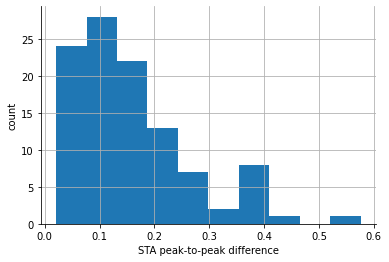

In [10]:
info['sta_p2p'].hist()
plt.xlabel('STA peak-to-peak difference')
plt.ylabel('count')
box_off()

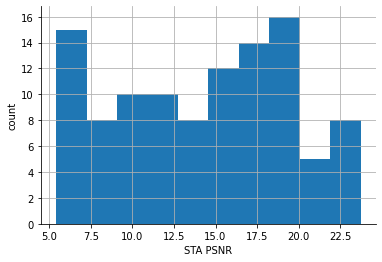

In [11]:
info['sta_psnr'].hist()
plt.xlabel('STA PSNR')
plt.ylabel('count')
box_off()

In [12]:
idx_high_snr = info['sta_p2p'] >= 0.35
info[idx_high_snr].sort_values(by='sta_p2p', ascending=False)

,channel,cell_type,number of spikes,sta std,sta max,sta min,sta_p2p,sta_psnr
70,ch_51a,Unknown,748,0.023695,0.938456,0.362703,0.575753,22.356631
52,ch_41b,ON,1280,0.022052,0.892096,0.445768,0.446327,18.798149
68,ch_48d,ON,4279,0.016892,0.838096,0.438113,0.399455,21.776471
105,ch_87c,ON,5117,0.016004,0.733737,0.338609,0.395361,22.761882
92,ch_74c,ON,8095,0.015104,0.726142,0.336820,0.389176,23.717369
87,ch_71b,OFF,1358,0.019762,0.762100,0.375838,0.386263,18.175707
78,ch_58a,Unknown,770,0.020992,0.699960,0.318880,0.380984,17.006550
47,ch_37c,ON,3646,0.015716,0.812484,0.438070,0.374644,21.811326
41,ch_35c,ON,8689,0.014652,0.701510,0.333548,0.367961,23.001142
51,ch_41a,ON,5911,0.014084,0.720316,0.357797,0.362520,23.548625


In [13]:
if len(info['cell_type'].value_counts()) == 3: # ON, OFF, Unknown
    group_values = ['ON', 'OFF', 'Unknown']
    color=['r','#00A0FF', '#A0A0A0']
elif len(info['cell_type'].value_counts()) == 4: # ON, OFF, ON-OFF, Unknown
    group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown']
    color=['r','#00A0FF','green', '#A0A0A0']    

In [14]:
info.groupby('cell_type', sort=False).mean()

,number of spikes,sta std,sta max,sta min,sta_p2p,sta_psnr
cell_type,,,,,,
ON-OFF,16609.382353,0.007116,0.569409,0.462052,0.107317,13.877413
ON,8980.523810,0.011152,0.620176,0.442516,0.177489,14.030017
OFF,14488.588235,0.009704,0.613810,0.434200,0.179539,17.052015
Unknown,5303.846154,0.013991,0.629886,0.426120,0.202710,12.781634


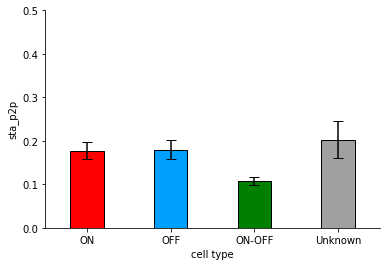

In [15]:
plot_bar_by_group(info, 'sta_p2p',
                  group_values = group_values, color=color)

plt.ylim(0, 0.5)
plt.savefig("figure/sta/{}_p2p_bar.pdf".format(dataset), bbox_inches='tight')
plt.savefig("figure/sta/{}_p2p_bar.png".format(dataset), bbox_inches='tight')

In [16]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info, 'sta_p2p', 'cell_type')

t, p = stats.ttest_ind(data['ON'], data['OFF'], equal_var=False)
print(p)

t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['Unknown'], equal_var=False)
print(p)

0.9439356418103438
0.5921266005632457


In [17]:
idx_high_snr = info['sta_psnr'] >= 8
info[idx_high_snr]

,channel,cell_type,number of spikes,sta std,sta max,sta min,sta_p2p,sta_psnr
1,ch_13a,ON,34400,0.004449,0.524178,0.486052,0.038108,8.372716
2,ch_13b,ON,9483,0.007966,0.561088,0.479195,0.081927,9.546151
8,ch_17a,ON-OFF,10553,0.004830,0.522330,0.478669,0.043356,8.637318
14,ch_21c,ON,744,0.021098,0.678991,0.437334,0.241657,10.751853
16,ch_22b,ON,9427,0.006506,0.561001,0.479463,0.081545,12.176788
...,...,...,...,...,...,...,...,...
101,ch_86a,OFF,8918,0.011459,0.685100,0.391667,0.293403,23.400269
102,ch_86b,OFF,11685,0.006805,0.588128,0.460443,0.127718,17.559977
103,ch_87a,ON-OFF,23387,0.006672,0.582740,0.455379,0.127247,17.737024
104,ch_87b,ON-OFF,4304,0.008134,0.554649,0.471234,0.083376,9.993480


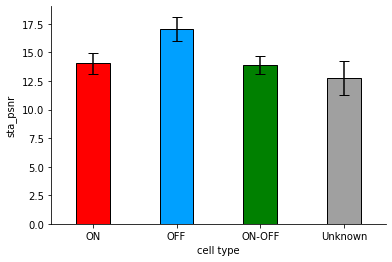

In [18]:
plot_bar_by_group(info, 'sta_psnr',
                  group_values = group_values, color=color)

plt.savefig("figure/sta/{}_psnr_bar.pdf".format(dataset), bbox_inches='tight')
plt.savefig("figure/sta/{}_psnr_bar.png".format(dataset), bbox_inches='tight')

In [19]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info, 'sta_psnr', 'cell_type')

t, p = stats.ttest_ind(data['ON'], data['OFF'], equal_var=False)
print(p)

t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['Unknown'], equal_var=False)
print(p)

# t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['ON-OFF'], equal_var=False)
# print(p)

0.036465802031538104
0.2126779454598189


## spatio-temporal analysis of RF with ON or OFF RGC with high peak-to-peak difference

In [20]:
# choose a channel with highest p2p
idx_on = info['cell_type'] == 'ON'
idx_off = info['cell_type'] == 'OFF'
idx = np.logical_or(idx_on, idx_off)

#ch_idx = info.loc[idx]['sta_p2p'].idxmax()
ch_idx = info.loc[idx]['sta_psnr'].idxmax()   #PSNR is better criteria

In [21]:
channel_name = info['channel'][ch_idx]
cell_types = info['cell_type'][ch_idx]
print(channel_name, cell_types)

ch_74c ON


(3026, 64, 8)
peak-to-peak diff. = 0.39


/Users/yyoo/src/pysta2/pysta.py:428: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  axes.append(plt.subplot(2, T / 2, t + 1))


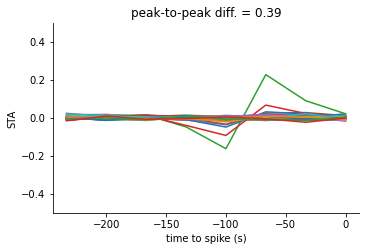

<Figure size 432x288 with 0 Axes>

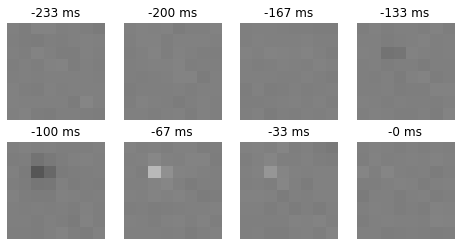

In [22]:
if fps == 10:
    tap = 8
elif fps == 25:
    tap = 20

spike_triggered_stim, weights = pysta.grab_spike_triggered_stim(stim, spike_counts[ch_idx], tap=tap)

sta = np.average(spike_triggered_stim, weights=weights, axis=0)
# sta.shape

print(spike_triggered_stim.shape)


import os
if not os.path.exists(os.path.join('figure', 'sta')):
    os.makedirs(os.path.join('figure', 'sta'))
    
plot_spatio_temporal(sta, 
                     width=width, height=height,
                     ylabel='STA',
                     fig_basename=os.path.join('figure', 'sta', channel_name))
# plt.title(channel_name + '(%.2f)'.format)

### spatial spectrum

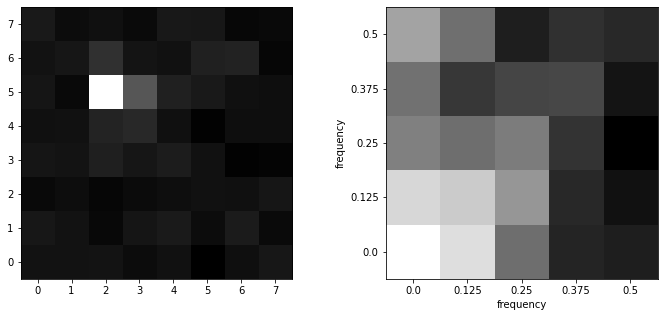

In [23]:
sta_slice = sta[:,5].reshape(height,width)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(sta_slice, cmap='gray', origin='lower')

plt.subplot(122)
plot_spatial_spectrum(sta_slice)

### temporal spectrum

peak-to-peak diff. = 0.39


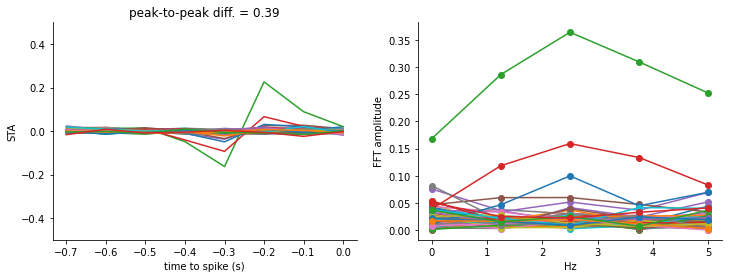

In [24]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plot_temporal_profile(sta, 1/fps)

plt.subplot(122)
plot_temporal_spectrum(sta, 1/fps)

plt.savefig(dataset + '_' + channel_name + '.pdf')
